# Time domain forward modelling and inversion notebook V0.1

In [8]:
# import SimPEG.dask as simpeg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import time_domain as tdem, utils as EMutils
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from scipy.interpolate import interp1d


## Loading the simulation

Load the *.msh file and *.mod file which are UBC formatted. We can extract the active cells by searching for the value used to indicate air cells on line 10 of the following cell

A histogram of the model is generated to get an idea of how many units are present

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\mixins\mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(77988,) 77988 60820


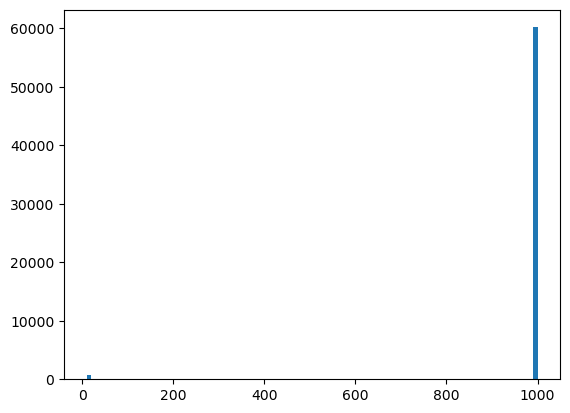

0.001 0.1


In [6]:
# let import the mesh in UBC format
mesh_file = r"C:\Users\johnk\Documents\git\jresearch\PGI\tdem\octree_mesh\output_files\octree_mesh.txt"
mesh = discretize.TreeMesh.readUBC(mesh_file)

# load the conductivity model
conductivity_file = r"C:\Users\johnk\Documents\git\jresearch\PGI\tdem\octree_model\octree_model.con"
model = discretize.TreeMesh.readModelUBC(mesh, conductivity_file)

# extract the acive files
actinds = model > 1e-8

print(model.shape, mesh.nC, actinds.sum())

plt.hist(1 / model[actinds], 100)
plt.show()

print(model[actinds].min(), model[actinds].max())


## Load the receiver stations array

Simply load in a CSV file with utm easting, northing and elevation.

receiver numbers: (100, 3)


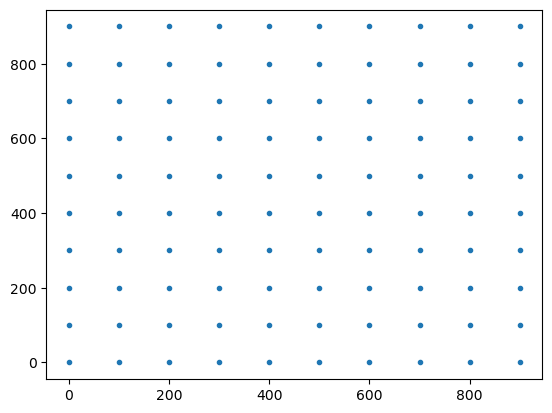

In [7]:
# create receivers
rx_x, rx_y = np.meshgrid(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
receivers = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.ones((np.prod(rx_x.shape), 1))*50.0))
print(f"receiver numbers: {receivers.shape}")

plt.plot(receivers[:, 0], receivers[:, 1], '.')
plt.show()


## Setting up the simulation

Here the background is set to the median of the model provided. This may or may not need to be adjusted depedning on the experiment.

The simpeg framework is now incorporated by defining the receiver type and components. This can be modified for impedance data or tipper. For tipper data replace the receiver simpeg object type with: `Point3DTipper(receivers, orientation=rx_orientation, component='real')` and `Point3DTipper(receivers, orientation=rx_orientation, component='imag')` on starting on line 12 and 17.

The model slice is also generated to confirm simulated targets.

In [29]:
# set signal times
offtime_steps = [
    1.000000e-04,
    1.584893e-04,
    2.511886e-04,
    3.981072e-04,
    6.309573e-04,
    1.000000e-03,
    1.584893e-03,
    2.511886e-03,
    3.981072e-03,
    6.309573e-03,
    1.000000e-02,
]

time_steps = [
    (1e-3, 5),
    (1e-4, 5),
    (5e-5, 10),
    (5e-5, 5),
    (1e-4, 10),
    (5e-4, 10),
]

background = 1000.0 # np.median(model[actinds])
# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1 / background
sigBG[~actinds] = 1e-8

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=actinds, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the simulation object
sim = tdem.Simulation3DMagneticFluxDensity(
    mesh,
    sigmaMap=mapping,
    solver=Solver
)
sim.time_steps = time_steps

# Make a receiver list
# Use VTEM waveform
out = EMutils.VTEMFun(np.array(sim.times), 0.00595, 0.006, 100)

# Forming function handle for waveform using 1D linear interpolation
wavefun = interp1d(sim.times, out)
t0 = 0.006
waveform = tdem.Src.RawWaveform(off_time=t0, waveform_function=wavefun)

rx = [tdem.Rx.PointMagneticFluxTimeDerivative(
    receivers[ii, :], np.array(offtime_steps) + t0, "z"
) for ii in range(receivers.shape[0])] 


src_list = [tdem.Src.CircularLoop(
    [rx[ii]], waveform=waveform, location=receivers[ii, :], radius=10.0
) for ii in range(receivers.shape[0])]

survey = tdem.Survey(src_list)

# create observed data
# survey.drape_topography(mesh, actinds, option='top')                       # drape topo

# plot the mesh
# model_plot = model.copy()
# model_plot[~actinds] = np.nan
# ind_slice = int(10)
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(111)
# mesh.plotSlice(model_plot, normal="X", ax=ax, ind=ind_slice, grid=True)
# ax.axis("equal")
# print(out.shape, np.logspace(-4, -2.5, 11))
# plt.plot(time_steps, out)
# plt.show()


## Running the forward simulation

Here simpeg map and simulation objects are created which are then used to calculate the forward data using the geological model imported in UBC format.

In [30]:

# # Set the mapping
# actMap = maps.InjectActiveCells(
#     mesh=mesh, indActive=actinds, valInactive=np.log(1e-8)
# )
# mapping = maps.ExpMap(mesh) * actMap

# # Setup the simulation object
# sim = tdem.Simulation3DMagneticFluxDensity(
#     mesh,
#     survey=survey,
#     sigmaMap=mapping,
#     time_steps=time_steps,
#     solver=Solver
# )
sim.survey = survey
sim.survey.dtrue = sim.dpred(np.log(model[actinds]))
# # create observations
# sim.survey.dobs = sim.survey.dtrue


ValueError: Points outside of mesh

## Plotting the simulation data

Line 11 and 20 will need to be adjusted accoringly depending on the data being observed.

[3.53273647e-04 3.53661917e-04 3.53667765e-04 ... 8.75008074e+01
 8.75023752e+01 8.75008523e+01]
212


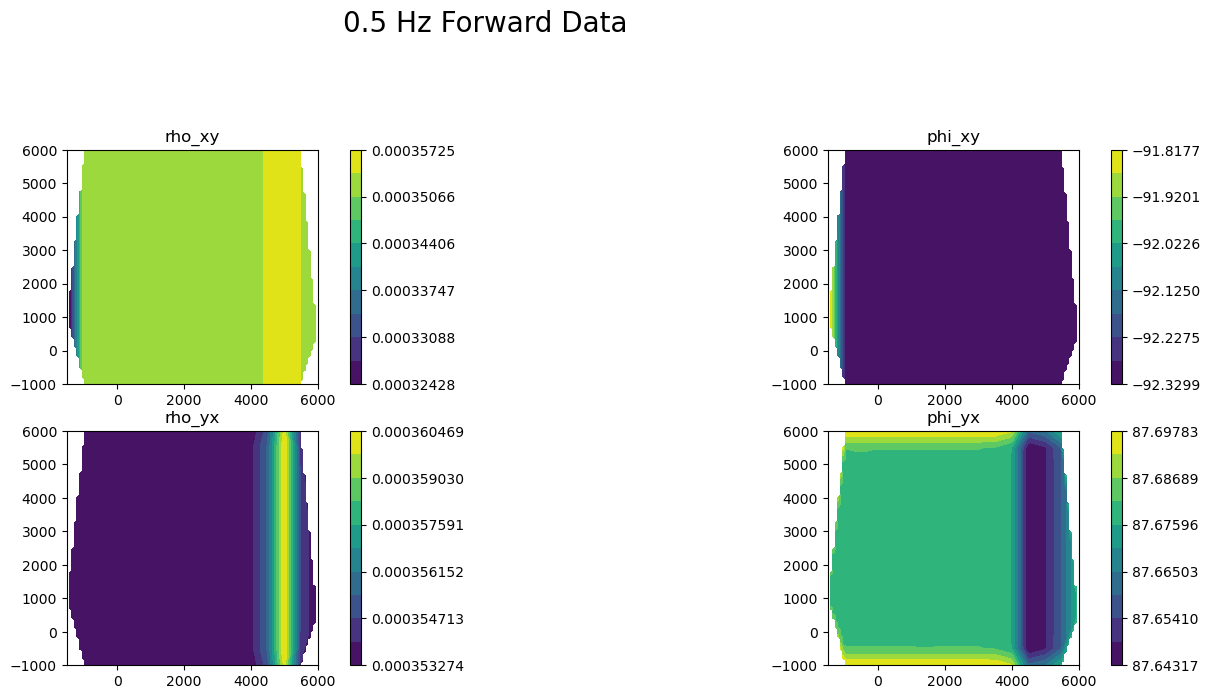

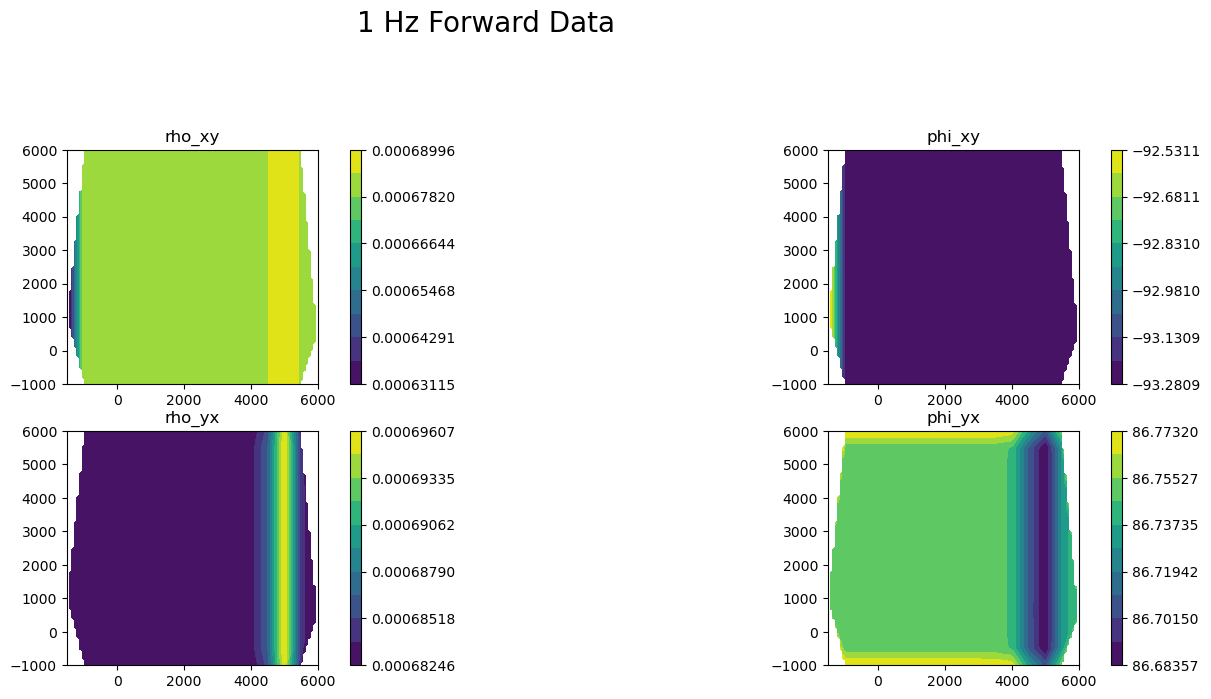

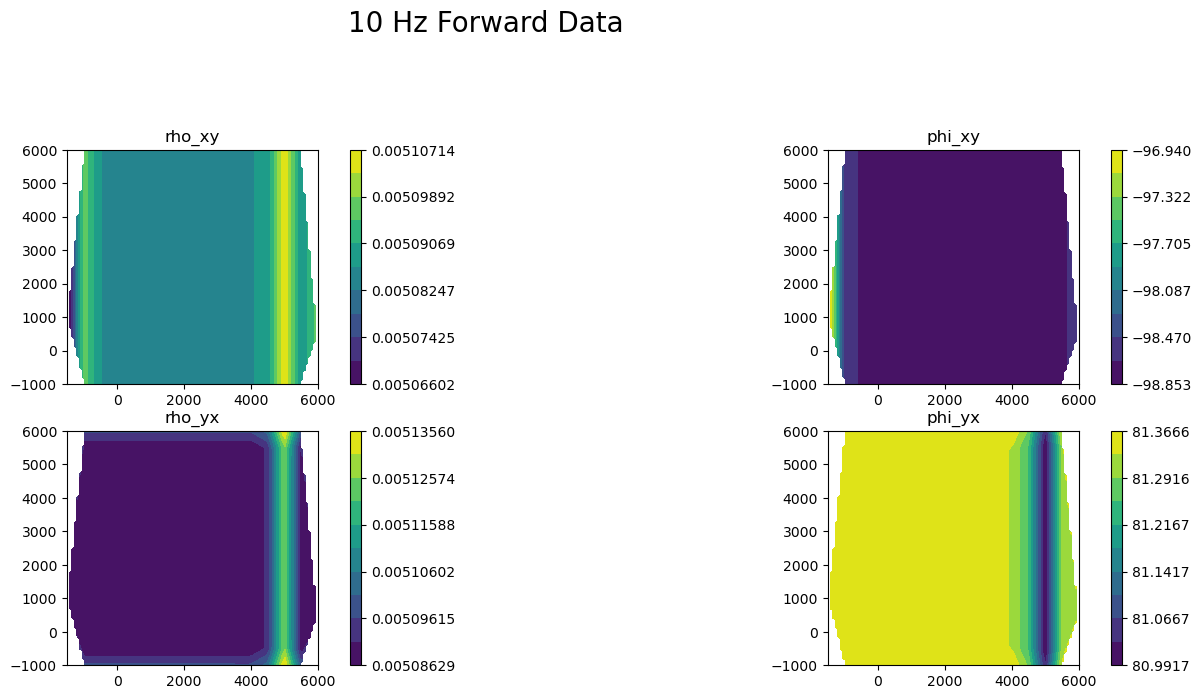

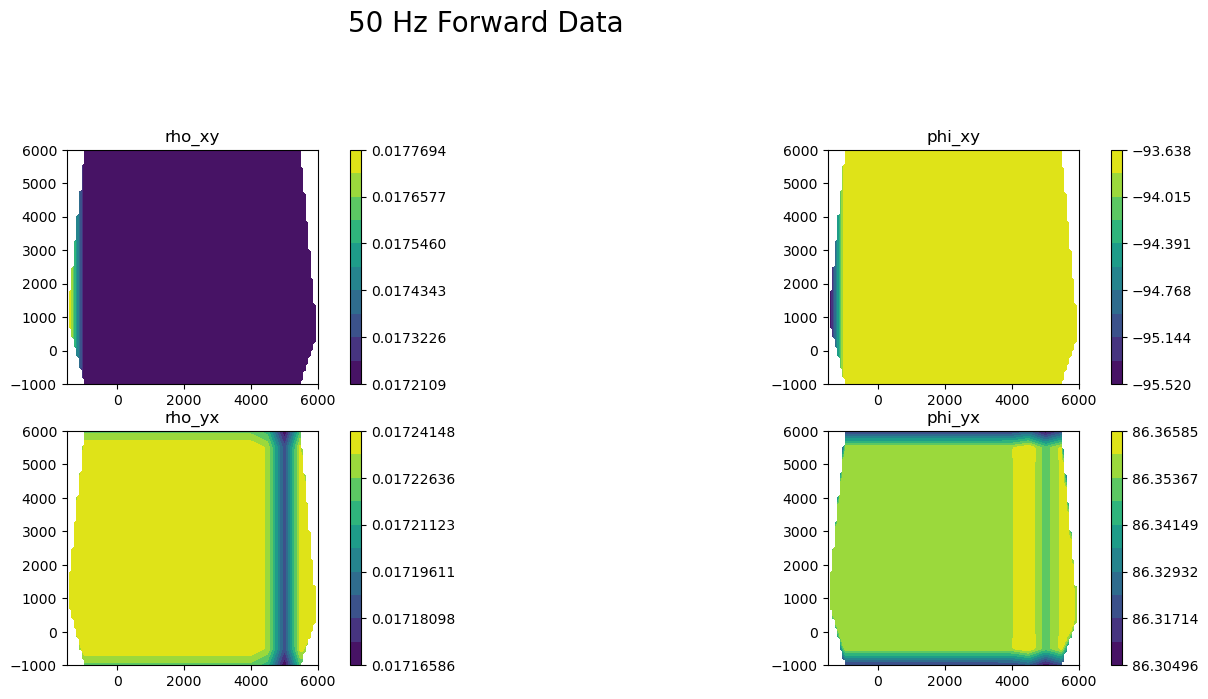

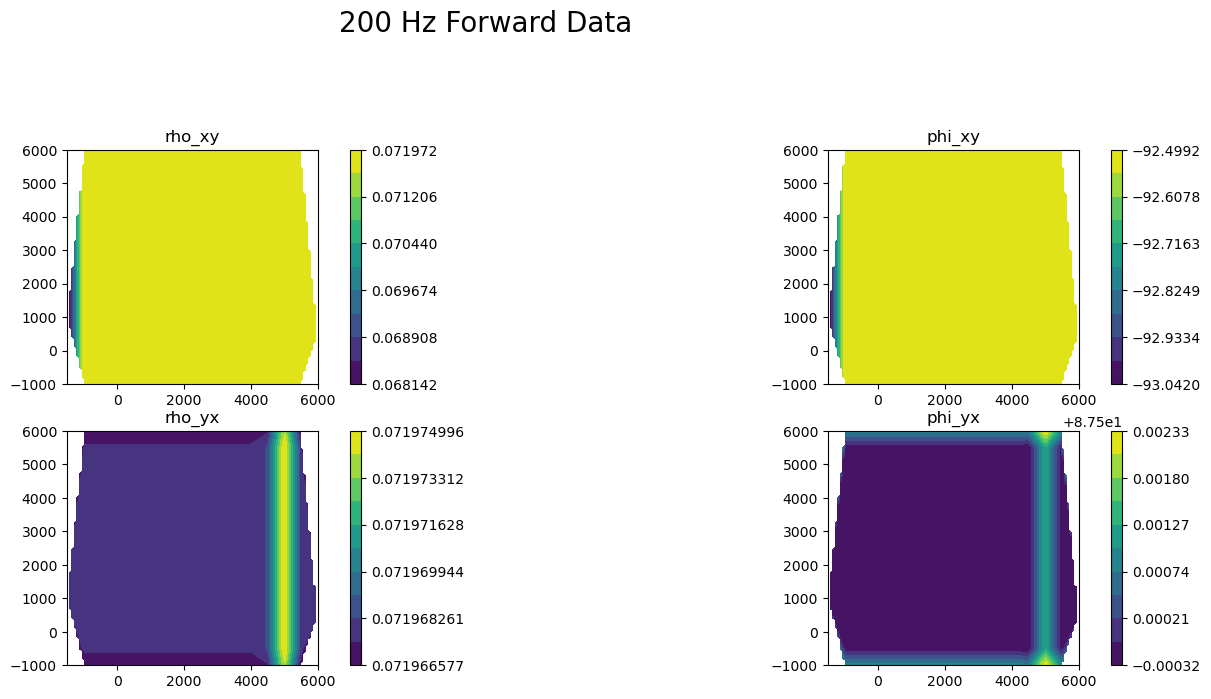

[1.76636823e-05 3.41227709e-05 2.54848103e-04] (4240,)


In [9]:
print(survey.dobs)
# Assign uncertainties
std = 0.05  # 5% std
sim.survey.std = np.abs(survey.dobs) * std
# make data object
fwd_data = data.Data(sim.survey)

gates = [
    1.000000e-04,
    1.584893e-04,
    2.511886e-04,
    3.981072e-04,
    6.309573e-04,
    1.000000e-03,
    1.584893e-03,
    2.511886e-03,
    3.981072e-03,
    6.309573e-03,
    1.000000e-02,
]

# reshape data for plotting
print(receivers.shape[0])
num_station = receivers.shape[0]

num_frequencies = len(gates)

num_sets = int(survey.dobs.shape[0] / len(gates))
dnew = np.reshape(survey.dobs, (num_frequencies, num_sets))
stdnew = np.reshape(survey.std, (num_frequencies, num_sets))

cnt = 0

for freq in gates:
    cnt_comp = 0
    # comps_ = ['rho_xy', 'phi_xy', 'rho_yx', 'phi_yx']
    comps_ = ['z']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        pert = 1e-3
        pert_diag = 0  #np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 10)
        if comps_[rx_orientation][-2:] == 'xx':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        elif comps_[rx_orientation][-2:] == 'yy':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        else:
#             print(pert_diag)
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + pert_diag
            
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receivers, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz Forward Data', fontsize='20')
plt.show()
print(mkvc(stdnew)[:3], stdnew.flatten('F').shape)

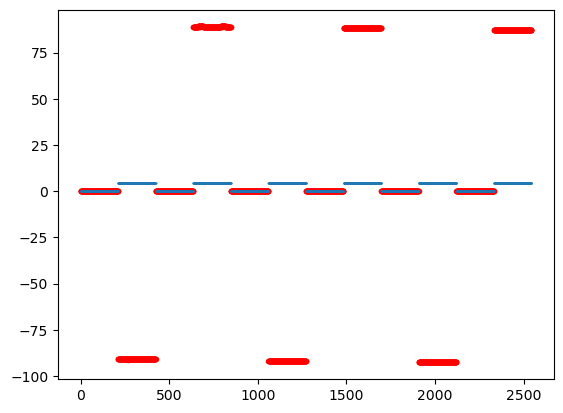

In [87]:
# np.save('Lb-imp_all-obs.npy', survey.dobs)
# np.save('Lb-imp-all-dpred_pre.npy', invProb.dpred)
# plt.plot(mkvc(stdnew), '.r')
# plt.plot(survey.std, '.', ms=1)
# plt.show()

## Fill the data object
fwd_data.dobs = sim.survey.dobs
fwd_data.standard_deviation = stdnew.flatten()  # sim.survey.std
sim.survey.std = stdnew.flatten()
survey.std = stdnew.flatten()

plt.plot(survey.dobs, '.r')
plt.plot(survey.std, '.', ms=1)
plt.show()

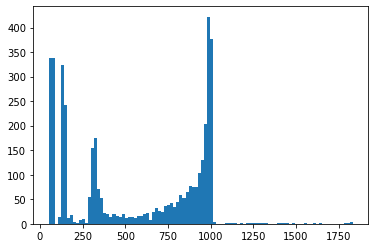

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


C:\Users\johnk\Anaconda3\envs\simpeginv\lib\site-packages\discretize-0.8.1-py3.9-win-amd64.egg\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradxStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\johnk\Anaconda3\envs\simpeginv\lib\site-packages\discretize-0.8.1-py3.9-win-amd64.egg\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradyStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\johnk\Anaconda3\envs\simpeginv\lib\site-packages\discretize-0.8.1-py3.9-win-amd64.egg\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradzStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (169,) of n blocks: 169




 block size: (

KeyboardInterrupt: 

In [9]:
Wd = 1 / survey.std
plt.hist(Wd, 100)
plt.show()
# Setup the inversion proceedure
# Define a counter
C = utils.Counter()
# Optimization
opt = optimization.ProjectedGNCG(maxIter=1, upper=np.inf, lower=-np.inf)
opt.counter = C
opt.maxIterCG = 20
# opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=fwd_data, simulation=sim)
dmis.W = Wd
# Regularization
regmap = maps.IdentityMap(nP=int(active.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)
reg = regularization.Simple(mesh, indActive=active, mapping=regmap)

reg.alpha_s = 4e-6
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta schedule
beta = directives.BetaSchedule()
beta.coolingRate = 1.
beta.coolingFactor = 4.
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
# targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta, beta_est, targmis, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))

In [88]:
print(invProb.beta, invProb.phi_d, invProb.phi_m, sim.survey.nD)
# map the conductivity
cond_est = mapping * mopt

# discretize.TensorMesh.writeUBC(mesh,'Lb-imp_all_simple-octree-v2.msh', models={'Lb-imp_all_simple-octree-v2.con': cond_est})

8.974059128801113e-08 1488.359407795853 3352236105.622183 4056


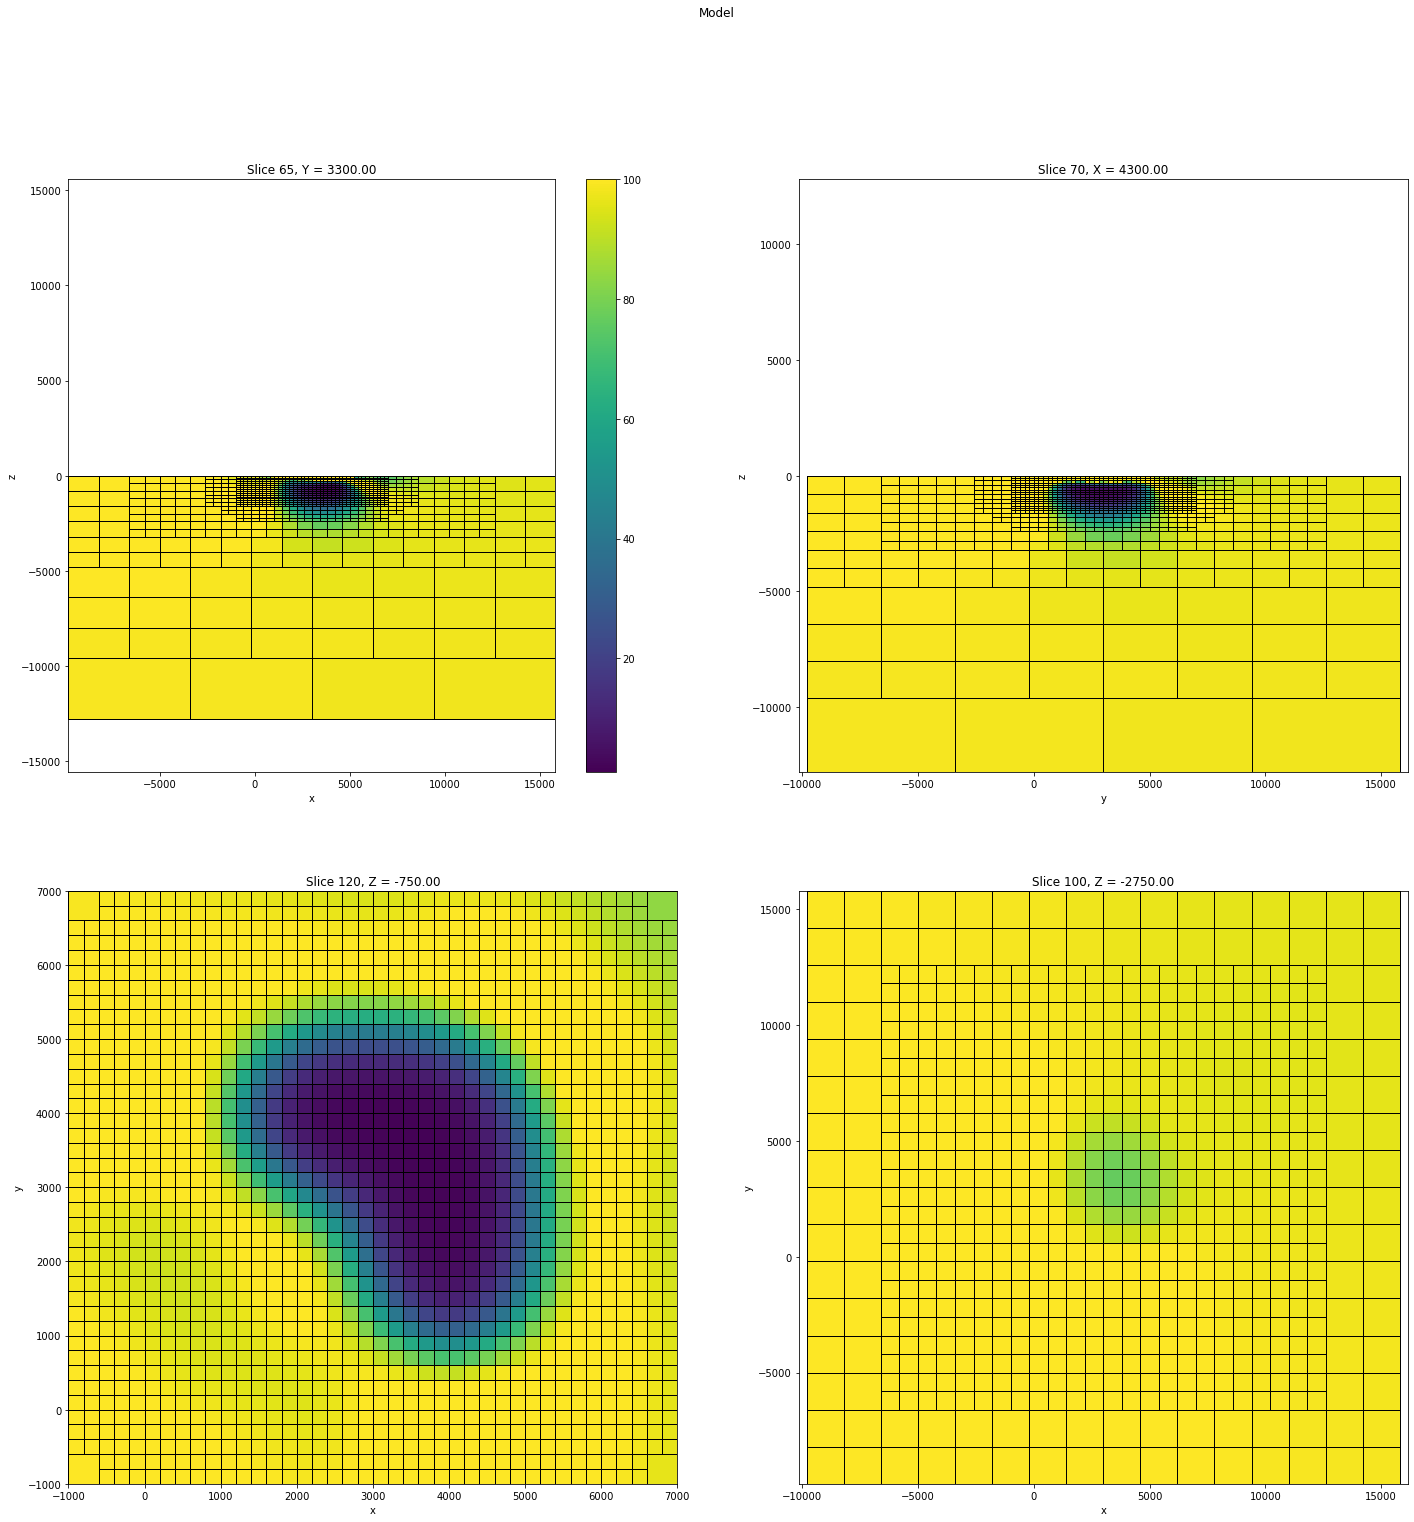

In [89]:
# modeli = np.ones(mesh.nC) 
modeli = 1 / cond_est
modeli[~active] = np.nan
# modeli[active] = cond_est
plt.figure(figsize=(24, 24))
plt.suptitle('Model')
ax = plt.subplot(2, 2, 1)
collect_obj = mesh.plot_slice(modeli, ax=ax, ind=int(65), grid=True, normal='Y', clim=[1, 100])
color_bar = plt.colorbar(collect_obj[0])
ax.axis('equal')
ax1 = plt.subplot(2, 2, 2)
collect_obj1 = mesh.plot_slice(modeli, ax=ax1, ind=int(70), grid=True, normal='X', clim=[1, 100])
# color_bar1 = plt.colorbar()
ax1.axis('equal')
# plt.show()

ax2 = plt.subplot(2, 2, 3)
collect_obj2 = mesh.plot_slice(modeli, ax=ax2, ind=int(120), grid=True, normal='Z', clim=[1, 100])
# color_bar2 = plt.colorbar()
ax2.set_xlim([-1000, 7000])
ax2.set_ylim([-1000, 7000])
# ax2.axis('equal')
# plt.show()

ax3 = plt.subplot(2, 2, 4)
collect_obj3 = mesh.plot_slice(modeli, ax=ax3, ind=int(100), grid=True, normal='Z', clim=[1, 100])
# color_bar3 = plt.colorbar()
ax3.set_xlim([-5000, 30000])
ax3.axis('equal')
plt.show()

# print(mesh.nCz)

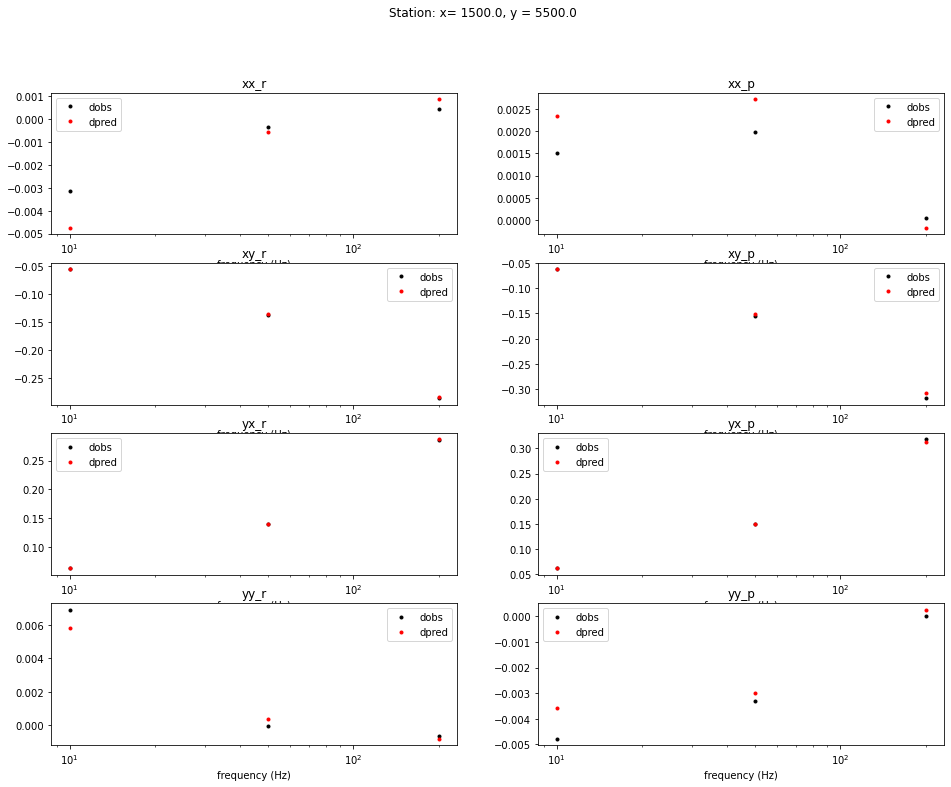

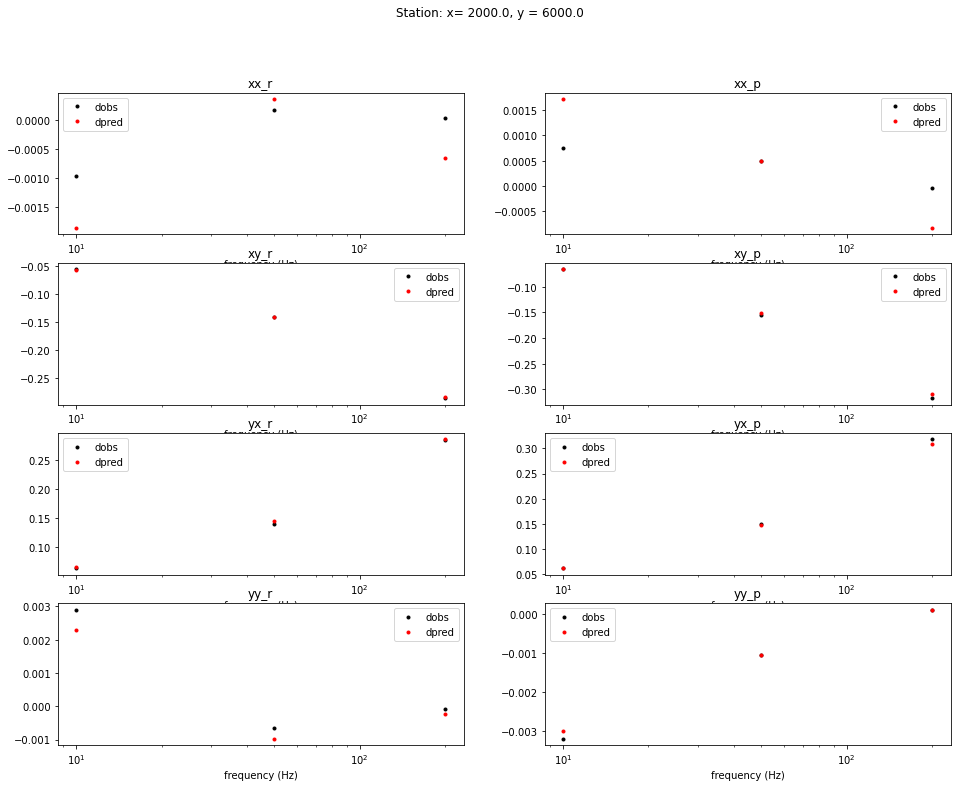

In [90]:
# plot dpred & dobs for specific station - checking fit of each frequency for a station
num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
# set station ID
stn_id = 50
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

# set second station ID
stn_id = 64
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

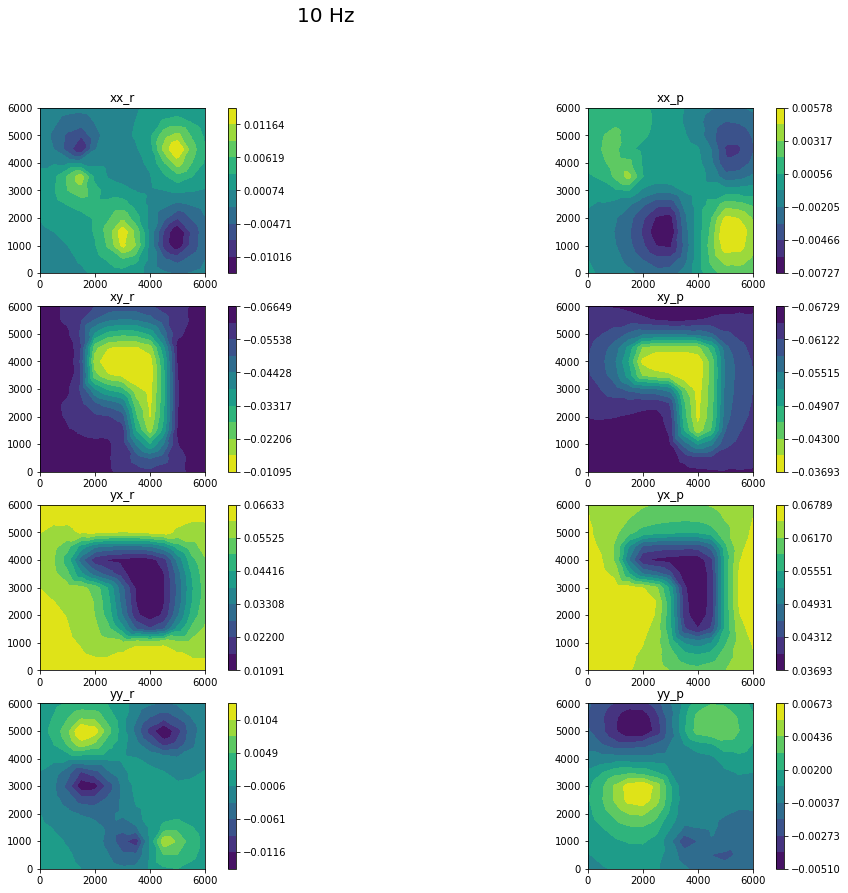

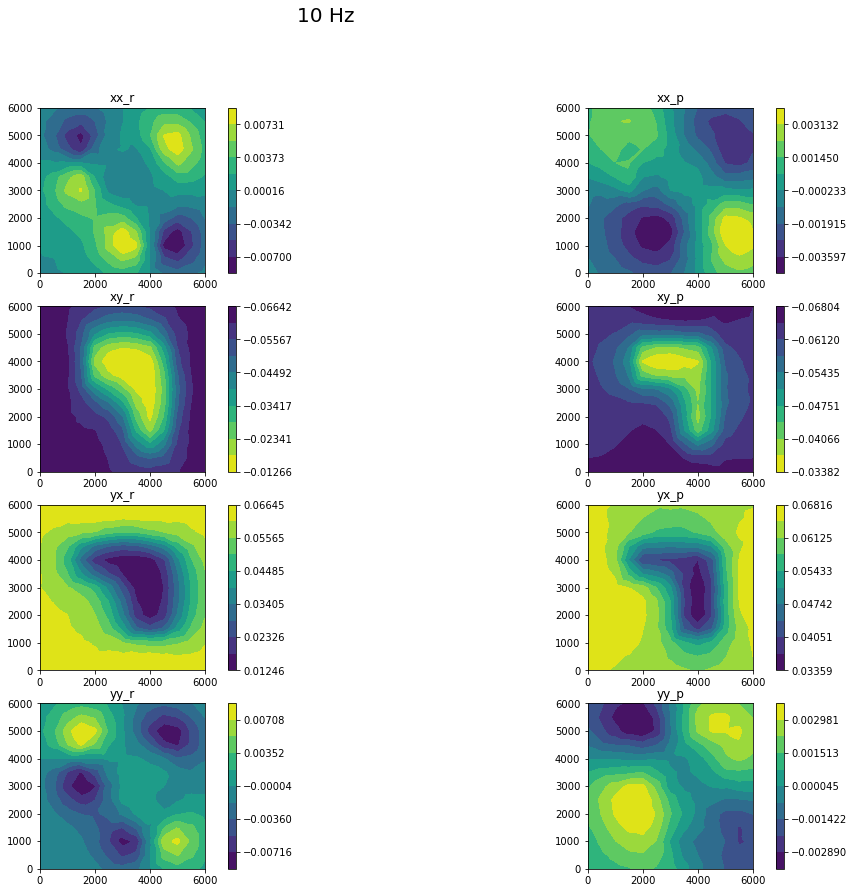

In [91]:
# plotting obs maps
freqs = ['10', '50', '200']
cnt = 0
cnt_comp = 0
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

# plotting dpred maps
fig2 = plt.figure(figsize=(18, 14))
cnt_comp = 0
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig2.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

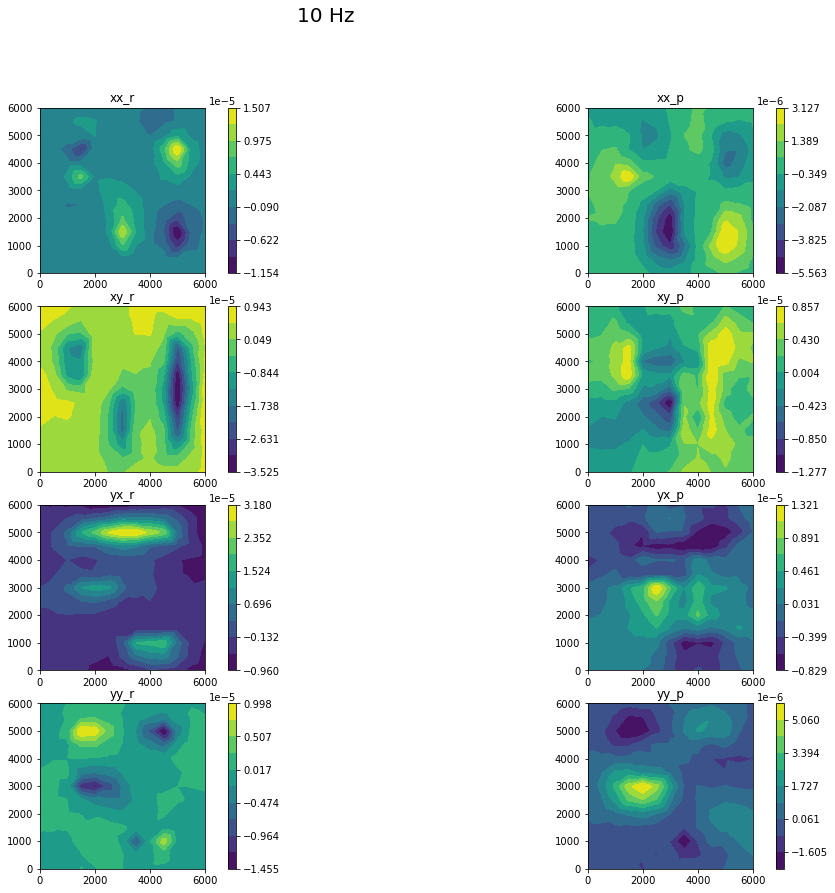

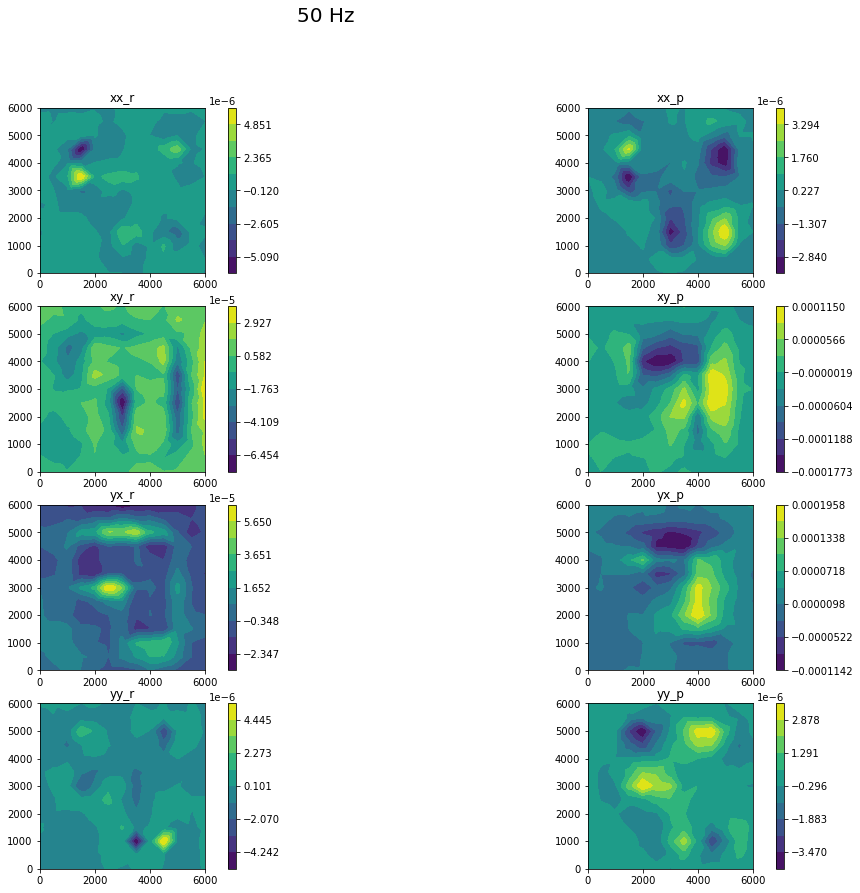

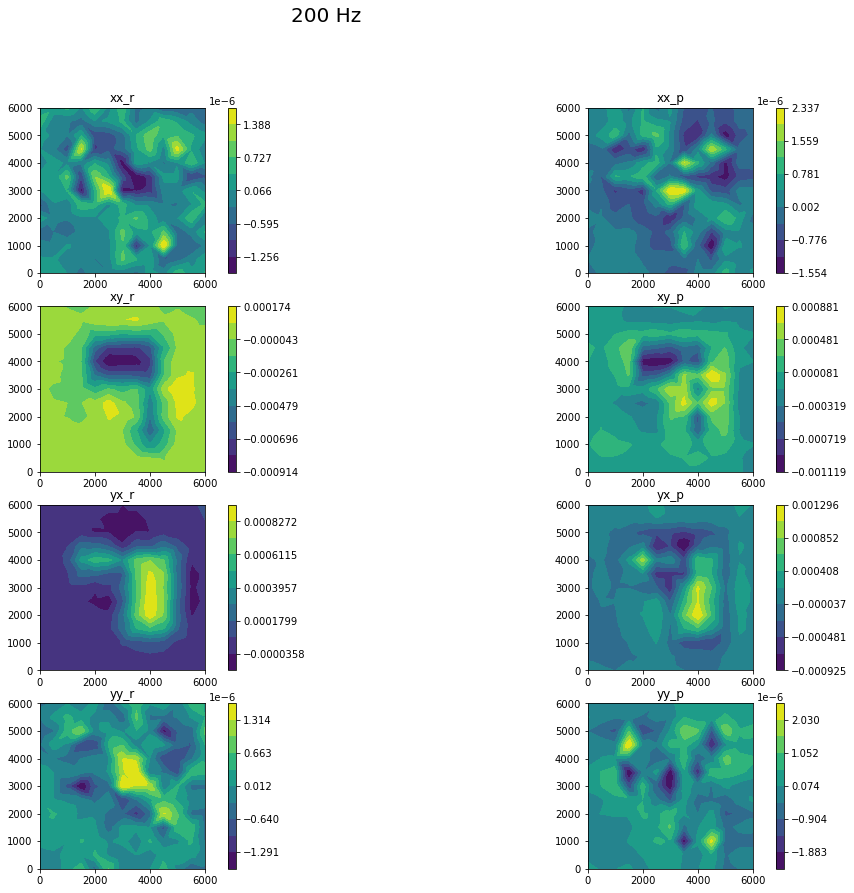

In [92]:
# plotting residual maps
freqs = ['10', '50', '200']
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']

cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        im = utils.plot_utils.plot2Ddata(rx_loc, residual, ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz', fontsize='20')
plt.show()

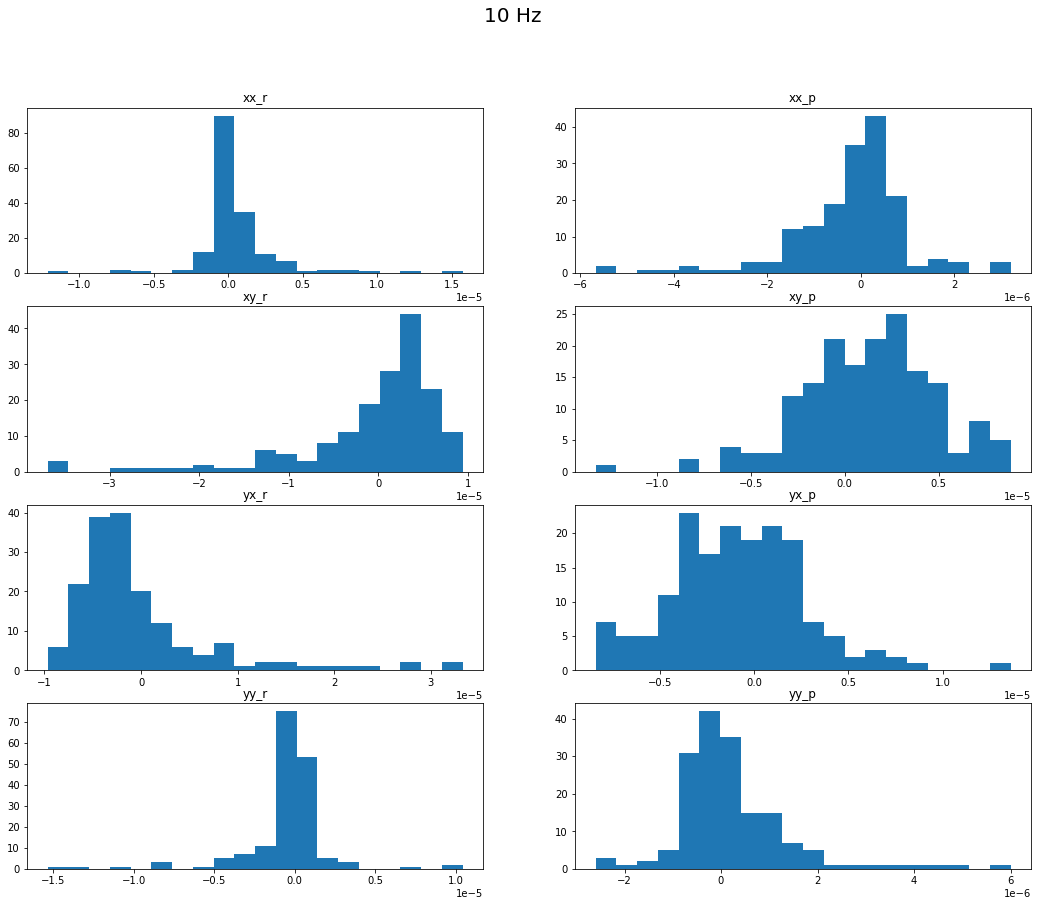

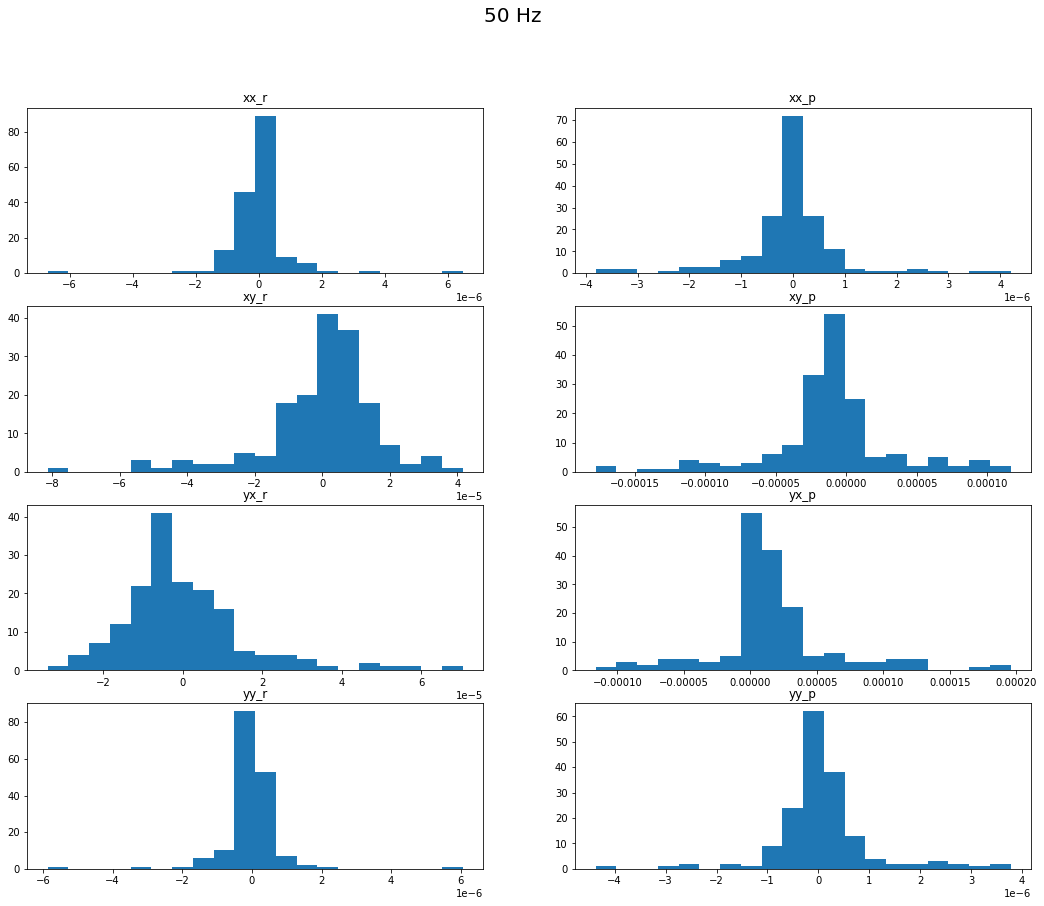

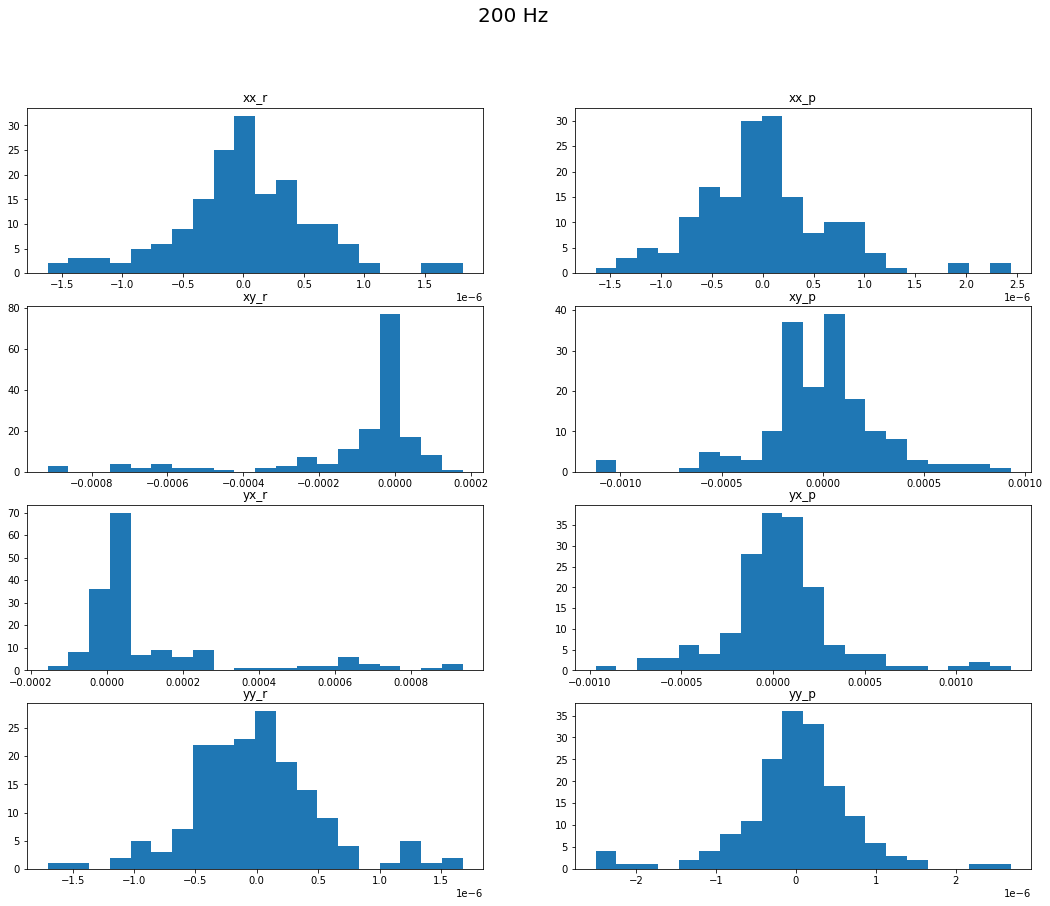

In [93]:
# plotting residual histograms
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        ax.hist(residual, 20)
        ax.set_title(comps_[rx_orientation])
        cnt_comp += 1
    cnt += 1
    fig.suptitle(freq + ' Hz', fontsize='20')
plt.show()

In [ ]:
np.save('Lb-imp_all-octree-obs-v2.npy', survey.dobs)
np.save('Lb-imp_all-octree-dpred-v2.npy', invProb.dpred)
np.save('Lb-imp_all-octree-dmis-v2.npy', d_wd)
print(5000 / 60)